# Due to one of the sweeping, found that electrolyte consumption just happen ridicously quick during RPT, even with very low V_EC, which I don't understand! So need to focous on RPT now. 

In [15]:
# magic lines that avoid re-start and load module
%load_ext autoreload
%autoreload 2
import pybamm as pb;import pandas as pd   ;import numpy as np;
import os;
import matplotlib.pyplot as plt;import os;#import imageio
from scipy.io import savemat,loadmat;from pybamm import constants,exp;import matplotlib as mpl; fs=17; # or we can set import matplotlib.pyplot as plt then say 'mpl.rc...'
import openpyxl
import traceback
import multiprocessing
import scipy.optimize
import timeit
import random;import time, signal
fs=17;
font = {'family' : 'DejaVu Sans','size'   : fs}
mpl.rc('font', **font)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
# Set Experiment : Exp-2
#########  Actively sweep parameters  ##############
Para_active = {
   "Ageing temperature":[25,], # 25, 40 
   "Initial electrolyte excessive amount ratio":[ 1.01], # set to <1 for DryOut=Off
   # rate of dry-out:
   "EC partial molar volume [m3.mol-1]":[4.8e-5,] ,
   # interstitial-diffusion limited
   'Inner SEI lithium interstitial diffusivity [m2.s-1]':[3e-20],    
   # LiP and coupling with SEI:
   "Dead lithium decay constant [s-1]":[ 1e-6,],            # default: 1e-6
   'Lithium plating kinetic rate constant [m.s-1]':[1E-10], # default: 1e-9
   # Crack model
   "Negative electrode LAM constant proportional term [s-1]":[ 1e-8], # default: 2.7778e-07
   "Positive electrode LAM constant proportional term [s-1]":[ 1e-16,], # default: 2.7778e-07
   "Negative electrode cracking rate":[ 1e-20,],   # default: function, ~3.9e-20 
}

In [17]:
# Inactively sweep parameters
Para_dict_Same = {
   #"Positive electrode cracking rate":[ 1e-22,],   # default: function, ~3.9e-20 
   "Cycles within RPT":[1,],
   "RPT temperature":[25,],
   "Mesh list":[[5,5,5,60,20],],   # Simon uses 30
   "Para_Set":[ "OKane2023",], # Li2023_Coupled
   "Model option":[
      {
         "contact resistance": "true",
         "open-circuit potential": "current sigmoid",
         "thermal": "lumped",
         "SEI": "interstitial-diffusion limited",
         "SEI on cracks": "true",
         "SEI film resistance": "distributed", 
         "SEI porosity change": "true",
         "particle mechanics": ("swelling and cracking", "swelling only"),
         "loss of active material": "stress-driven",
         "lithium plating": "partially reversible",
      },
      ],
   "Contact resistance [Ohm]": [0.0105,],   
   "Current solvent concentration in the reservoir [mol.m-3]":[4541.0,],
   "Current electrolyte concentration in the reservoir [mol.m-3]":[1000,],
   "Ratio of Li-ion concentration change in electrolyte consider solvent consumption":[1.0,],
   'EC initial concentration in electrolyte [mol.m-3]':[4541.0,],
   'Typical EC concentration in electrolyte [mol.m-3]':[4541.0,], # Mark Ruihe change, act as an initial value here
}
Para_dict_All = {**Para_dict_Same,**Para_active}
Para_dict_list = []
def recursive_scan(mylist,kvs, key_list, acc):
    if len(key_list) == 0:
        mylist.append(acc.copy())  
        return mylist
    k = key_list[0]
    for v in kvs[k]:
        acc[k] = v
        # print(v)
        recursive_scan(mylist,kvs, key_list[1:], acc)

recursive_scan(Para_dict_list,Para_dict_All, list(Para_dict_All.keys()), {})
print(f"Total scan case is {len(Para_dict_list)}")

Total scan case is 1


In [18]:
# define expeirment
V_max = 4.2;        V_min = 2.5; 
exp_RPT_text = [ (
    # refill
    f"Hold at {V_max}V until C/100",
    "Rest for 1 hours (20 minute period)", 
    # 0.1C cycle 
    f"Discharge at 0.1C until {V_min} V (30 minute period)",  
    "Rest for 3 hours (20 minute period)",  
    f"Charge at 0.1C until {V_max} V (30 minute period)",
    f"Hold at {V_max}V until C/100",
    "Rest for 1 hours (20 minute period)",
    # 0.5C cycle 
    f"Discharge at 0.5C until {V_min} V (6 minute period)",  
    "Rest for 3 hours (20 minute period)",
    f"Charge at 0.5C until {V_max} V (6 minute period)",
    f"Hold at {V_max}V until C/100",
    "Rest for 3 hours (20 minute period)",  
    ) ] * 1
# step index for RPT
step_0p1C_CD = 2; step_0p1C_CC = 4;   step_0p1C_RE =3;    
step_0p5C_CD = 7;  

In [21]:
Experiment_RPT    = pb.Experiment( exp_RPT_text*1 ) 
Experiment_Breakin= Experiment_RPT
Para_dict_i = Para_dict_list[0]
Scan_i = 1
def Para_init(Para_dict):
    Para_dict_used = Para_dict.copy();
    Para_0=pb.ParameterValues(Para_dict_used["Para_Set"]  )
    Para_dict_used.pop("Para_Set")

    if Para_dict_used.__contains__("Total ageing cycles"):
        Total_Cycles = Para_dict_used["Total ageing cycles"]  
        Para_dict_used.pop("Total ageing cycles")
    if Para_dict_used.__contains__("Ageing cycles between RPT"):
        Cycle_bt_RPT = Para_dict_used["Ageing cycles between RPT"]  
        Para_dict_used.pop("Ageing cycles between RPT")
    if Para_dict_used.__contains__("Update cycles for ageing"):
        Update_Cycles = Para_dict_used["Update cycles for ageing"]  
        Para_dict_used.pop("Update cycles for ageing")
    if Para_dict_used.__contains__("Cycles within RPT"):
        RPT_Cycles = Para_dict_used["Cycles within RPT"]  
        Para_dict_used.pop("Cycles within RPT")
    if Para_dict_used.__contains__("Ageing temperature"):
        Temper_i = Para_dict_used["Ageing temperature"]  + 273.15 # update: change to K
        Para_dict_used.pop("Ageing temperature")
    if Para_dict_used.__contains__("RPT temperature"):
        Temper_RPT = Para_dict_used["RPT temperature"] + 273.15 # update: change to K 
        Para_dict_used.pop("RPT temperature")
    if Para_dict_used.__contains__("Mesh list"):
        mesh_list = Para_dict_used["Mesh list"]  
        Para_dict_used.pop("Mesh list")
    if Para_dict_used.__contains__("Exponential mesh stretch"):
        submesh_strech = Para_dict_used["Exponential mesh stretch"]  
        Para_dict_used.pop("Exponential mesh stretch")
    else:
        submesh_strech = "nan";
    if Para_dict_used.__contains__("Model option"):
        model_options = Para_dict_used["Model option"]  
        Para_dict_used.pop("Model option")

    if Para_dict_used.__contains__("Initial Neg SOC"):
        c_Neg1SOC_in = (
            Para_0["Maximum concentration in negative electrode [mol.m-3]"]
            *Para_dict_used["Initial Neg SOC"]  )
        Para_0.update(
            {"Initial concentration in negative electrode [mol.m-3]":
            c_Neg1SOC_in})
        Para_dict_used.pop("Initial Neg SOC")
    if Para_dict_used.__contains__("Initial Pos SOC"):    
        c_Pos1SOC_in = (
            Para_0["Maximum concentration in positive electrode [mol.m-3]"]
            *Para_dict_used["Initial Pos SOC"]  )
        Para_0.update(
            {"Initial concentration in positive electrode [mol.m-3]":
            c_Pos1SOC_in})
        Para_dict_used.pop("Initial Pos SOC")

    CyclePack = [ 
        Temper_i,Temper_RPT,mesh_list,submesh_strech,model_options];
    # Mark Ruihe - updated 230222 - from P3
    for key, value in Para_dict_used.items():
        # risk: will update parameter that doesn't exist, 
        # so need to make sure the name is right 
        if isinstance(value, str):
            Para_0.update({key: eval(value)})
            #Para_dict_used.pop(key)
        else:
            Para_0.update({key: value},check_already_exists=False)

    return CyclePack,Para_0

CyclePack,Para_0 = Para_init(Para_dict_i)
[
    Temper_i,Temper_RPT,mesh_list,
    submesh_strech,model_options] = CyclePack

temp_Int_ElelyExces_Ratio =  Para_0[
    "Initial electrolyte excessive amount ratio"] 
ce_EC_0 = Para_0['EC initial concentration in electrolyte [mol.m-3]'] 

Model_0 = pb.lithium_ion.DFN(options=model_options ) #
var = pb.standard_spatial_vars  
var_pts = {
    var.x_n: int(mesh_list[0]),  
    var.x_s: int(mesh_list[1]),  
    var.x_p: int(mesh_list[2]),  
    var.r_n: int(mesh_list[3]),  
    var.r_p: int(mesh_list[4]),  }       
Sim_0    = pb.Simulation(
    Model_0,        experiment = Experiment_Breakin,
    parameter_values = Para_0,
    solver = pb.CasadiSolver(),
    var_pts=var_pts,) 
Sol_0    = Sim_0.solve(calc_esoh=False)

At t = 1311.32 and h = 8.76289e-11, the corrector convergence failed repeatedly or with |h| = hmin.


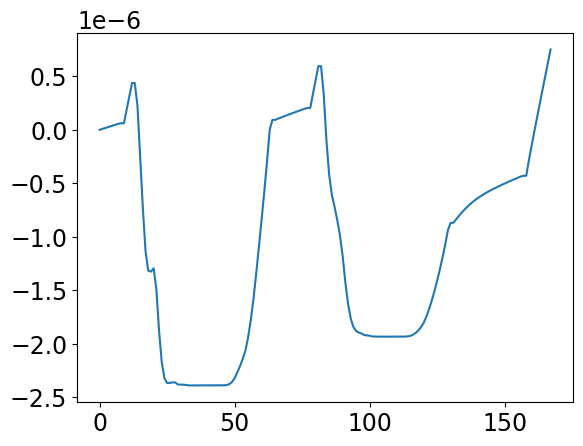

In [22]:
plt.plot(Sol_0["Loss of capacity to SEI [A.h]"].entries)